In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Random Field as Spatial Point Process

Suppose $Y$ is a Gaussian Random Field on the unit square $S=[0, 1]^2$. We discretize the unit square into an $M\times M$ grid with cells
$$
    D_{ij} = [(i-1)/M,\, i/M] \times [(j-1)/M,\, j/M]
$$
with centers
$$
    (c_i, c_j) = ((2i + 1)/2M,\, (2j + 1)/2M)
$$
We now take the lexicographic ordering of the indices
$$
    k = 2Mi + M(2Mj - 1)
$$
Such that
$$
    Y = (Y_i, \dots, Y_{M^2})^T
$$
Now, our problem is to simulate $Y \sim \mathcal{N}_{M^2}(0, \Sigma)$ with covariance matrix elements given by
$$
    C(||(c_i, c_j) - (c_i', c_j')||) = \sigma^2r(||(c_i, c_j) - (c_i', c_j')||/\alpha)
$$
where $r$ is a positive semi-definite correlataion function . Usually,
$$
    r(||\xi - \eta||/\alpha) = \exp \left(||\xi - \eta||^\delta/\alpha \right),\,\,\, \delta \in [0, 2]
$$
In principle, we could take the Cholesky decomposition of $\Sigma = GG^T$, with $G$ lower triangular, and define $Y = Gx$, with $x \sim \mathcal{N}_{M^2}(0, 1)$, but the covariance matrix has a shape of $M^2 \times M^2$ and the Cholesky decomposition take $\mathcal{O}(n^3)$ operation to compute.

## Fourier Decomposition

The idea is now to take advantage of the fact that $\Sigma$ is positive semi-definite and is a Toeplitz matrix. Indeed, a Toeplitz matrix must have elements $A_{i, j}$ satisfying
$$
    A_{i, j} = a_{i-j}
$$
Exemple:
$$
\left(
    \begin{matrix}
        a_0 & a_{-1} & a_{-2} \\
        a_1 & a_0 & a_{-1} \\
        a_2 & a_1 & a_0
    \end{matrix}
\right)
$$
It seasy to see from the definition of $C$ that $\Sigma$ satisfies this condition. 

Now the trick is to embed the $[0, 1]$ space into a $[0, 2]$ circle with $2M$ cells (2 is the circumference). For our 2 dimensional space, this means we embedded the square grid into a torus with 4 times the number of cells. Suppose $d_{ij}$ is the minimum distance on this circle between $c_i$ and $c_j$. Now, 
$$
    \Sigma_{\text{ext}} = (C(d_{ij}))_{(i, j)\in I_{\text{ext}}}
$$
$\Sigma_{\text{ext}}$ is now a circulant matrix! This is important, because the Fourier Transform diagonalize circulant matrix, defined by the additionnal property that $a_i = a_{i + n}$ with $n\times n$ being the dimension of the square matrix.
$$
\left(
    \begin{matrix}
        a_0 & a_{2} & a_{1} \\
        a_1 & a_0 & a_{2} \\
        a_2 & a_1 & a_0
    \end{matrix}
\right)
$$

The idea is then to draw from $X_{\text{ext}} \sim \mathcal{N}_{2M}(0, \Sigma_{\text{ext}})$, transfrom it to get
$$
    Y_{\text{ext}} \sim \mathcal{F} \Lambda^{1/2} \mathcal{F}^{H} X_{\text{ext}}
$$
from which we extract the firct $M$ values in order to get the Gaussian Random Field. Here, $\Lambda$ is the diagonal decomposition of $\Sigma_{\text{ext}}$ defined by eigenvalues
$$
    \lambda_j = \sum_{i = 1}^{2M-1}c_i\exp(-2\pi ij/2M)
$$
with $c_i$ an element of a row or column of $\Sigma_{\text{ext}}$. This was using a 1D signal of size M. For a 2D signal, we wrap the space $S$ into a torus like mentionned earlier and obtain a block-circulant matrix, that can be diagonalized by some sort of 2D fourier transform.

In [2]:
# example of a block circulant matrix (each block is circulant, and the block matrix is as well)
C = np.array([[1, 2, 3, 4], [2, 1, 4, 3], [3, 4, 1, 2], [4, 3, 2, 1]])
C

array([[1, 2, 3, 4],
       [2, 1, 4, 3],
       [3, 4, 1, 2],
       [4, 3, 2, 1]])

In [3]:
# This is diagonalized by a 2D DFT, that is
def dft_matrix(M):
    omega = np.exp(-1j * 2 * np.pi / M)
    return np.array([[omega**(i * j) for i in range(M)] for j in range(M)]) / np.sqrt(M)

M = 2
F_m = dft_matrix(M) # along first dimension
F_n = dft_matrix(M) # along second dimension

In [4]:
# Now, the 2D transform is obtained by taking the Kronecker product of the 2 transforms
FF = np.kron(F_m, F_n)
FF.shape

(4, 4)

$$
    \mathcal{F}_2^H C \mathcal{F}_2
$$

In [5]:
D = FF.conj().T @ C @ FF

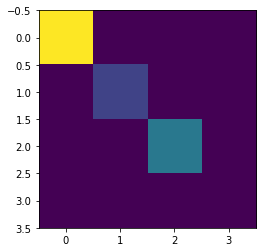

In [6]:
plt.imshow(np.abs(D))

In [7]:
# We can get the same result with FFT
c = C[:, 0].reshape((-1, M)) # first column of each block
c

array([[1, 2],
       [3, 4]])

In [8]:
X = np.fft.fft2(c) # gives out the diagonal in matrix form 
D_fft = np.eye(M**2) * X.reshape(-1) # reshape it into the same shape as before

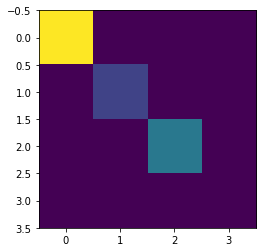

In [9]:
plt.imshow(np.abs(D_fft))

# Gaussian Random Field

In [163]:
# Now to our main goal, as we said, all we need is the first column or row of Sigma_ext
def covariance_function(var, alpha=0.01, delta=2):
    """
    This is an isotropic and translation invariant correlation function
    
    delta = 1: stable correlation function
    delta = 1/2: exponential correlation function
    delta = 2: Gaussian correlation function
    
    alpha = correltaion parameter
    
    return the log of the correlation function (to be numerically stable), which assumes xi and alpha to be complex numbers (2d vectors) 
    """
    # return the torus distance
    def r(xi, eta):
        diff = np.minimum(np.abs(xi - eta), 2 - np.abs(xi - eta)) # torus euclidian distance with radius 2
        amp = np.sqrt(np.einsum("...i, ...i -> ...", diff, diff))
        log_floor = 1e-16
        return var * np.exp(- amp**delta / alpha)
    return r



Map the square $[0, 2]^2$ on the torus $S^1 \times S^1$ 

In [198]:
# problem is in the ordering of the position
def torus_grid(M):
    """
    Return a 2M \times 2M flat torus grid of radius 2 
    """
    x = np.linspace(0, 2, 2 * M)
    xx, yy = np.meshgrid(x, x, indexing='ij') # square grid
    return np.column_stack([xx.ravel(), yy.ravel()])
    


In [225]:
M = 5
alpha =4
delta = 2
cov_func = covariance_function(1, alpha, delta)
u = torus_grid(M) # position of the center of each cell
cov_ext_row_one = cov_func(u[0], u) # first row of the covariance matrix of the torus

## Diagonalize

$$
    \Lambda = \sqrt{M} (\mathcal{F} \otimes \mathcal{F})(\mathbf{c})
$$
Lets call the 2D transform $\mathcal{F}_2 \equiv \mathcal{F} \otimes \mathcal{F}$
$$
    Y_{\text{ext}} = \mathcal{F}_2 (\Lambda^{1/2} \odot \mathcal{F}^H_2(X_{\text{ext}}))
$$
where 
$$
    X_{ext} \sim \mathcal{N}_{4M^2}(0, 1)
$$

In [226]:
# Now, diagonalize
Lambda = np.sqrt(M) * np.fft.fft2(np.reshape(cov_ext_row_one, (-1, 2 * M))).flatten()

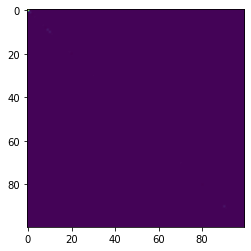

In [227]:
if M < 12:
    D_fft = np.eye(4 * M**2) * Lambda# reshape it into the same shape as before
    plt.imshow(np.real(D_fft))

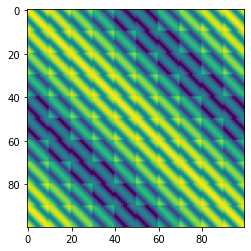

In [228]:
if M < 12:
    covariance = np.column_stack([cov_func(u[i], u) for i in range(u.shape[0])])
    plt.imshow(covariance)

In [215]:
x_ext = np.random.normal(size=4*M**2)
b = np.sqrt(Lambda) * np.fft.ifft2(x_ext.reshape(( 2*M, -1))).flatten()
y_ext = np.fft.fft2(b[:M**2].reshape((M, -1))) # returns a real number, imaginary part is always close to zero as it should!
y_ext_r = np.real(y_ext)

(-0.5, 511.5, 511.5, -0.5)

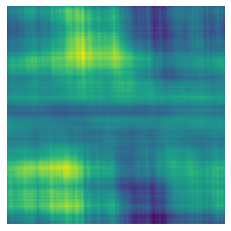

In [216]:
mu = 4.25
z = np.exp(y_ext_r)
# plt.imshow(density(y_ext_r + mu))
plt.imshow(y_ext_r)
plt.axis("off")

# Log Gaussian Cox Process

The Gaussian Random field can be used as the intensity of a poisson process
$$
    Z = \exp(Y)
$$
is a measure of density (or intensity). We want to sample from this distribution, using Metropolis-Hasting algorithm.


In [18]:
def metropolis_hasting(target_distribution, hops):
    # we assume a unit square field
    N = target_distribution.shape[0]
    
    burn_in = int(hops*0.2) * 0
    current = np.ones(2) * 0.5
    states = []
    for i in range(hops):
        movement = np.random.multivariate_normal(mean=current, cov=0.5 * np.eye(2))
        if movement[0] < 0 or movement[0] > 1 or movement[1] < 0 or movement[1] > 1:
            continue
        current_prob = target_distribution[int((N-1) * current[0]), int((N-1) * current[1])]
        movement_prob = target_distribution[int((N-1) * movement[0]), int((N-1) * movement[1])]
        acceptance = min(1, movement_prob/(current_prob))        
        if np.random.uniform() < acceptance:
            current = movement
            states.append(current)

    return np.array(states[burn_in:])
    

Text(0.5, 1.0, 'Uniform Random Poisson process')

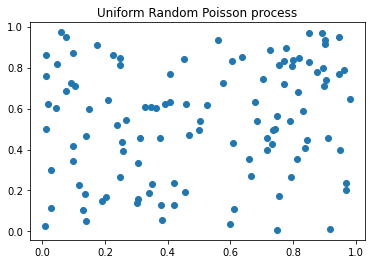

In [19]:
# Random Poisson process
n = np.random.poisson(100)
x = np.random.uniform(size=n)
y = np.random.uniform(size=n)
plt.scatter(x, y)
plt.title("Uniform Random Poisson process")

In [20]:
# states = metropolis_hasting(z, 100_000)

In [21]:
# plt.scatter(states[:, 0], states[:, 1], marker=".")

In [22]:
# len(states)

In [23]:
# movement = np.array([1.7, 0.25])
# movement = np.array([np.cos(2 * np.pi * movement[0]), np.cos(2 * np.pi * movement[1])])
# # now inverse this back into the unit square
# movement = np.array([np.arccos(movement[0])/2/np.pi, np.arccos(movement[1])/2/np.pi])

In [24]:
# movement

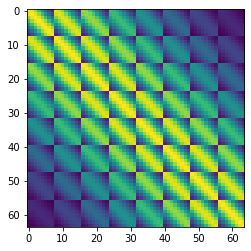

In [186]:
# here is the covariance matrix with block Toeplitz structure
M = 4
x = np.linspace(0, 1, 2 * M)
xx, yy = np.meshgrid(x, x)
nu = np.column_stack([xx.flatten(), yy.flatten()])
# ell = 2 * (np.cos(np.pi * xx) + 2 * 1j*  np.sin(np.pi * yy)).flatten()
# covariance = np.column_stack([cov_func(ell[i], ell) for i in range(ell.size)])
covariance = np.column_stack([cov_func(nu[i], nu) for i in range(nu.shape[0])]).T
plt.imshow(covariance)